# Implementation of AlexNet [1]
## Introduction
In this task, we use AlexNet [1] to make image classification on CIFAR-10 dataset [2].
1. We finetune AlexNet for 1 epoch on CIFAR-10 dataset.
2. We evaluate the finetuned AlexNet on CIFAR-10 dataset and report its accuracy.

All operations are run on the CPU.

[1] Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. "Imagenet classification with deep convolutional neural networks." Advances in neural information processing systems. 2012.\
[2] Krizhevsky, Alex, and Geoffrey Hinton. Learning multiple layers of features from tiny images. Vol. 1. No. 4. Technical report, University of Toronto, 2009.

## Import packages

In [1]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave

## Load training set of CIFAR-10

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
num_classes = 10

Files already downloaded and verified


## Build AlexNet

In [3]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = AlexNet(num_classes = num_classes)
print('Total params: %.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))

Total params: 2.47M


## Build loss & optimizer

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

## Load pretrained AlexNet
Training a full network needs GPU and many times. So we finetune the network based on the provided pretrained
model.

In [5]:
checkpoint = torch.load('pretrained/pretrained_alexnet.pth.tar')
model.load_state_dict({k.replace('module.',''):v for k,v in checkpoint['state_dict'].items()})

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Define AverageMeter & accuracy

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

## Finetune for 1 epoch

In [7]:
model.train()

batch_time = AverageMeter()
data_time = AverageMeter()
losses = AverageMeter()
top1 = AverageMeter()
top5 = AverageMeter()
end = time.time()

for batch_idx, (inputs, targets) in enumerate(trainloader):
    # measure data loading time
    data_time.update(time.time() - end)
    
    inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)
    
    # compute output
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # measure accuracy and record loss
    prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
    losses.update(loss.data.item(), inputs.size(0))
    top1.update(prec1.item(), inputs.size(0))
    top5.update(prec5.item(), inputs.size(0))

    # compute gradient and do SGD step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # measure elapsed time
    batch_time.update(time.time() - end)
    end = time.time()

    # plot progress
    if (batch_idx + 1) % 10 == 0:
        log = '({batch}/{size}) Data: {data:.2f}s | Batch: {bt:.2f}s | Total: {total:.2f}s | ETA: {eta:.2f}s | Loss: {loss:.2f} | top1: {top1: .2f} | top5: {top5: .2f}'.format(
            batch=batch_idx + 1,
            size=len(trainloader),
            data=data_time.avg,
            bt=batch_time.avg,
            total=batch_time.sum,
            eta=batch_time.avg*(len(trainloader)-batch_idx-1),
            loss=losses.avg,
            top1=top1.avg,
            top5=top5.avg)
        print(log)

(10/391) Data: 0.22s | Batch: 3.10s | Total: 31.03s | ETA: 1182.06s | Loss: 0.15 | top1:  94.22 | top5:  100.00
(20/391) Data: 0.15s | Batch: 2.85s | Total: 56.93s | ETA: 1055.98s | Loss: 0.15 | top1:  94.61 | top5:  100.00
(30/391) Data: 0.12s | Batch: 2.74s | Total: 82.32s | ETA: 990.64s | Loss: 0.15 | top1:  94.64 | top5:  100.00
(40/391) Data: 0.10s | Batch: 2.67s | Total: 106.92s | ETA: 938.26s | Loss: 0.16 | top1:  94.51 | top5:  99.98
(50/391) Data: 0.09s | Batch: 2.68s | Total: 133.82s | ETA: 912.67s | Loss: 0.16 | top1:  94.39 | top5:  99.95
(60/391) Data: 0.09s | Batch: 2.63s | Total: 157.72s | ETA: 870.11s | Loss: 0.16 | top1:  94.38 | top5:  99.95
(70/391) Data: 0.09s | Batch: 2.61s | Total: 182.62s | ETA: 837.46s | Loss: 0.16 | top1:  94.24 | top5:  99.96
(80/391) Data: 0.08s | Batch: 2.60s | Total: 207.82s | ETA: 807.91s | Loss: 0.16 | top1:  94.25 | top5:  99.96
(90/391) Data: 0.08s | Batch: 2.58s | Total: 232.42s | ETA: 777.32s | Loss: 0.16 | top1:  94.28 | top5:  99.96

## Save finetuned model

In [8]:
def save_checkpoint(state, checkpoint='checkpoint', filename='checkpoint.pth.tar'):
    if not os.path.isdir(checkpoint):
        os.makedirs(checkpoint)
    filepath = os.path.join(checkpoint, filename)
    torch.save(state, filepath)

save_checkpoint({
    'model_name': 'finetuned_alexnet',
    'state_dict': model.state_dict()}, 
    checkpoint='checkpoint/alexnet/',
    filename='finetuned_alexnet.pth.tar')

In [9]:
# checkpoint = torch.load('checkpoint/alexnet/finetuned_alexnet.pth.tar')
# model.load_state_dict({k.replace('module.',''):v for k,v in checkpoint['state_dict'].items()})

## Load testing set of CIFAR-10

In [10]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_test)
testloader = data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)

## Evaluate finetuned AlexNet on CIFAR-10

In [11]:
# switch to evaluate mode
model.eval()

batch_time = AverageMeter()
data_time = AverageMeter()
losses = AverageMeter()
top1 = AverageMeter()
top5 = AverageMeter()
end = time.time()

for batch_idx, (inputs, targets) in enumerate(testloader):
    # measure data loading time
    data_time.update(time.time() - end)

    with torch.no_grad():
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)
        
        # compute output
        outputs = model(inputs)

    loss = criterion(outputs, targets)

    # measure accuracy and record loss
    prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
    losses.update(loss.data.item(), inputs.size(0))
    top1.update(prec1.item(), inputs.size(0))
    top5.update(prec5.item(), inputs.size(0))

    # measure elapsed time
    batch_time.update(time.time() - end)
    end = time.time()

    # plot progress
    if (batch_idx + 1) % 10 == 0:
        log = '({batch}/{size}) Data: {data:.2f}s | Batch: {bt:.2f}s | Total: {total:.2f}s | ETA: {eta:.2f}s | Loss: {loss:.2f} | top1: {top1: .2f} | top5: {top5: .2f}'.format(
            batch=batch_idx + 1,
            size=len(testloader),
            data=data_time.avg,
            bt=batch_time.avg,
            total=batch_time.sum,
            eta=batch_time.avg*(len(testloader)-batch_idx-1),
            loss=losses.avg,
            top1=top1.avg,
            top5=top5.avg)
        print(log)
print('Final accuracy: %.2f (top1), %.2f (top5)}'%(top1.avg, top5.avg))


(10/100) Data: 0.11s | Batch: 0.64s | Total: 6.44s | ETA: 57.96s | Loss: 0.73 | top1:  77.40 | top5:  98.80
(20/100) Data: 0.08s | Batch: 0.61s | Total: 12.24s | ETA: 48.95s | Loss: 0.77 | top1:  77.60 | top5:  98.60
(30/100) Data: 0.07s | Batch: 0.60s | Total: 17.93s | ETA: 41.85s | Loss: 0.81 | top1:  77.33 | top5:  98.33
(40/100) Data: 0.07s | Batch: 0.59s | Total: 23.43s | ETA: 35.15s | Loss: 0.82 | top1:  77.12 | top5:  98.28
(50/100) Data: 0.06s | Batch: 0.58s | Total: 29.14s | ETA: 29.14s | Loss: 0.83 | top1:  77.12 | top5:  98.22
(60/100) Data: 0.06s | Batch: 0.57s | Total: 34.34s | ETA: 22.89s | Loss: 0.82 | top1:  77.03 | top5:  98.30
(70/100) Data: 0.06s | Batch: 0.57s | Total: 39.64s | ETA: 16.99s | Loss: 0.82 | top1:  76.87 | top5:  98.31
(80/100) Data: 0.06s | Batch: 0.56s | Total: 45.04s | ETA: 11.26s | Loss: 0.83 | top1:  76.76 | top5:  98.33
(90/100) Data: 0.05s | Batch: 0.56s | Total: 50.84s | ETA: 5.65s | Loss: 0.82 | top1:  76.88 | top5:  98.34
(100/100) Data: 0.05s

## Visualization

In [12]:
categories = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [13]:
def get_rgb_img(idx, dataset):
    img = dataset[idx][0].numpy().transpose(1, 2, 0) 
    img = ((img * (0.2023, 0.1994, 0.2010) + (0.4914, 0.4822, 0.4465)) * 255).astype(np.uint8)
    return img

Categoriy: airplane, Possibility: 0.99
Categoriy: bird, Possibility: 0.00
Categoriy: cat, Possibility: 0.00


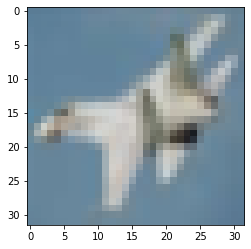

In [14]:
model.eval()

img_idx = 10
rgb_img = get_rgb_img(img_idx, testset)
imshow(rgb_img)
output = model(testset[img_idx][0].unsqueeze(0))
score = output.softmax(1).detach().numpy()

top3_idx = np.argsort(-score)[0][:3]
for i in top3_idx:
    print('Categoriy: %s, Possibility: %.2f'%(categories[i], score[0][i]))

Categoriy: frog, Possibility: 0.88
Categoriy: cat, Possibility: 0.10
Categoriy: dog, Possibility: 0.02


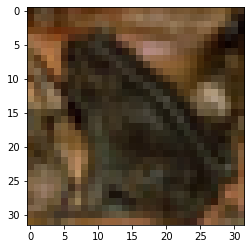

In [15]:
model.eval()

img_idx = 30
rgb_img = get_rgb_img(img_idx, testset)
imshow(rgb_img)
output = model(testset[img_idx][0].unsqueeze(0))
score = output.softmax(1).detach().numpy()

top3_idx = np.argsort(-score)[0][:3]
for i in top3_idx:
    print('Categoriy: %s, Possibility: %.2f'%(categories[i], score[0][i]))